In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
import joblib
#from pytorch_tabnet.tab_model import TabNetClassifier

import os

# Defining the path for the csv file
path = os.path.join("dataset.csv")

# Storing the dataframe in a variable named dataset
dataset = pd.read_csv(path)

# Dropping the unnecessary columns
dataset = dataset.drop('seqn', axis='columns')
dataset = dataset.drop('Marital', axis='columns')
print(dataset.shape)
print(len(dataset[dataset['MetabolicSyndrome'] == 0]))
print(len(dataset[dataset['MetabolicSyndrome'] == 1]))
print(1579+822)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Load the counterfactual data
result_df = pd.read_csv('counterfactual_pairs_all_with_outcomes.csv', index_col=0)

# Extract features and target
features = result_df.drop(columns=['Outcome'])
target = result_df['Outcome']

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['Outcome'] = target.values
pca_df['Index'] = result_df.index  # Preserve original/counterfactual labels

# Separate original and counterfactual points
originals = pca_df[pca_df['Index'].str.contains('Original')]
counterfactuals = pca_df[pca_df['Index'].str.contains('Counterfactual')]

# Plot decision boundaries
x_min, x_max = pca_df['PC1'].min() - 1, pca_df['PC1'].max() + 1
y_min, y_max = pca_df['PC2'].min() - 1, pca_df['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Train XGBoost on the PCA-transformed data
from xgboost import XGBClassifier
classifier_pca = XGBClassifier()
classifier_pca.fit(principal_components, target)
z = classifier_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Improved visualization
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFDDDD', '#DDDDFF'])
plt.contourf(xx, yy, z, alpha=0.3, cmap=cmap_light)

# Plot original and counterfactual points with better markers and transparency
sns.scatterplot(x='PC1', y='PC2', hue='Outcome', style='Index', data=pca_df, palette='coolwarm', alpha=0.8, edgecolor='black')

# Draw smoother connecting lines
for i in range(len(originals)):
    plt.plot([originals.iloc[i]['PC1'], counterfactuals.iloc[i]['PC1']],
             [originals.iloc[i]['PC2'], counterfactuals.iloc[i]['PC2']], 'k-', linewidth=0.7, alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundaries with Counterfactual Transformations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('counterfactual_pairs_with_outcomes.csv')

# Convert index column to string if it exists
if 'index' in df.columns:
    df['index'] = df['index'].astype(str)
    # Separate original and counterfactual examples
    original_rows = df[df['index'] == 'Original']
    counterfactual_rows = df[df['index'] == 'Counterfactual']
else:
    # Assume alternating rows if no index column
    original_rows = df.iloc[::2]  # Every even row
    counterfactual_rows = df.iloc[1::2]  # Every odd row

# Features to consider (excluding 'Outcome' and index-related columns)
features = ['Sex', 'Race', 'Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 
           'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on all feature values (both original and counterfactual)
all_features = df[features].values
scaler.fit(all_features)

# Transform the data
original_normalized = scaler.transform(original_rows[features])
counterfactual_normalized = scaler.transform(counterfactual_rows[features])

# 1. Calculate normalized average distance
distances = np.linalg.norm(original_normalized - counterfactual_normalized, axis=1)
avg_distance = np.mean(distances)
std_distance = np.std(distances)

# 2. Calculate sparsity (average number of changed features)
# Using 0.01 standard deviations as threshold for numerical features
THRESHOLD = 0.01

def calculate_changes(orig_row, cf_row, features):
    changes = []
    for feat in features:
        if feat in ['Sex', 'Race']:  # Categorical features
            changes.append(orig_row[feat] != cf_row[feat])
        else:  # Numerical features
            # Consider changed if difference is more than threshold standard deviations
            normalized_diff = abs(orig_row[feat] - cf_row[feat]) / df[feat].std()
            changes.append(normalized_diff > THRESHOLD)
    return sum(changes)

# Calculate number of changes for each pair
changes = []
for i in range(len(original_rows)):
    orig = original_rows.iloc[i]
    cf = counterfactual_rows.iloc[i]
    num_changes = calculate_changes(orig, cf, features)
    changes.append(num_changes)

avg_changes = np.mean(changes)
std_changes = np.std(changes)

# Print results
print("\nCounterfactual Performance Metrics:")
print("-" * 40)
print(f"1. Normalized Average Distance:")
print(f"   Mean: {avg_distance:.3f}")
print(f"   Std:  {std_distance:.3f}")
print("\n2. Feature Changes (Sparsity):")
print(f"   Mean: {avg_changes:.3f} features")
print(f"   Std:  {std_changes:.3f} features")
print(f"   Percentage: {(avg_changes/len(features))*100:.1f}% of features")

# Additional detailed statistics
print("\nDetailed Feature Change Analysis:")
print("-" * 40)

# Calculate percentage of pairs that change each feature
feature_change_rates = {}
for feat in features:
    if feat in ['Sex', 'Race']:  # Categorical features
        changes = (original_rows[feat].values != counterfactual_rows[feat].values).mean() * 100
    else:  # Numerical features
        normalized_diff = abs(original_rows[feat].values - counterfactual_rows[feat].values) / df[feat].std()
        changes = (normalized_diff > THRESHOLD).mean() * 100
    feature_change_rates[feat] = changes

# Sort features by change frequency
sorted_features = sorted(feature_change_rates.items(), key=lambda x: x[1], reverse=True)
for feat, rate in sorted_features:
    print(f"{feat:15} {rate:6.1f}% changed")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def calculate_changes(orig_row, cf_row, features, threshold=0.01):
    """Calculate number of changes between original and counterfactual rows."""
    changes = []
    for feat in features:
        if feat in ['Sex', 'Race']:  # Categorical features
            changes.append(orig_row[feat] != cf_row[feat])
        else:  # Numerical features
            normalized_diff = abs(orig_row[feat] - cf_row[feat]) / df[feat].std()
            changes.append(normalized_diff > threshold)
    return sum(changes)

def export_counterfactual_analysis(original_rows, counterfactual_rows, features, distances, changes, output_file='counterfactual_analysis_results.csv'):
    """Export counterfactual analysis results to a CSV file."""
    # Calculate overall metrics
    avg_distance = np.mean(distances)
    std_distance = np.std(distances)
    avg_changes = np.mean(changes)
    std_changes = np.std(changes)
    
    # Calculate feature-specific change rates
    feature_change_rates = {}
    for feat in features:
        if feat in ['Sex', 'Race']:  # Categorical features
            changes = (original_rows[feat].values != counterfactual_rows[feat].values).mean() * 100
        else:  # Numerical features
            normalized_diff = abs(original_rows[feat].values - counterfactual_rows[feat].values) / pd.concat([original_rows[feat], counterfactual_rows[feat]]).std()
            changes = (normalized_diff > 0.01).mean() * 100
        feature_change_rates[feat] = changes
    
    # Create DataFrames for each section
    overall_metrics = pd.DataFrame({
        'Metric': [
            'Normalized Average Distance (Mean)',
            'Normalized Average Distance (Std)',
            'Average Feature Changes (Mean)',
            'Average Feature Changes (Std)',
            'Percentage of Features Changed'
        ],
        'Value': [
            f'{avg_distance:.3f}',
            f'{std_distance:.3f}',
            f'{avg_changes:.3f}',
            f'{std_changes:.3f}',
            f'{(avg_changes/len(features))*100:.1f}%'
        ]
    })
    
    feature_metrics = pd.DataFrame({
        'Feature': list(feature_change_rates.keys()),
        'Change Rate (%)': [f'{rate:.1f}%' for rate in feature_change_rates.values()]
    }).sort_values('Change Rate (%)', ascending=False)
    
    # Add section headers and combine
    overall_metrics.insert(0, 'Section', 'Overall Metrics')
    feature_metrics.insert(0, 'Section', 'Feature-Specific Analysis')
    
    # Combine all results
    combined_results = pd.concat([overall_metrics, feature_metrics], ignore_index=True)
    
    # Export to CSV
    combined_results.to_csv(output_file, index=False)
    
    return combined_results

# Load the data
df = pd.read_csv('counterfactual_pairs_with_outcomes.csv')

# Convert index column to string if it exists
if 'index' in df.columns:
    df['index'] = df['index'].astype(str)
    # Separate original and counterfactual examples
    original_rows = df[df['index'] == 'Original']
    counterfactual_rows = df[df['index'] == 'Counterfactual']
else:
    # Assume alternating rows if no index column
    original_rows = df.iloc[::2]  # Every even row
    counterfactual_rows = df.iloc[1::2]  # Every odd row

# Features to consider (excluding 'Outcome' and index-related columns)
features = ['Sex', 'Race', 'Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 
           'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']

# Initialize and fit StandardScaler
scaler = StandardScaler()
all_features = df[features].values
scaler.fit(all_features)

# Transform the data
original_normalized = scaler.transform(original_rows[features])
counterfactual_normalized = scaler.transform(counterfactual_rows[features])

# Calculate normalized distances
distances = np.linalg.norm(original_normalized - counterfactual_normalized, axis=1)

# Calculate number of changes for each pair
changes = []
for i in range(len(original_rows)):
    orig = original_rows.iloc[i]
    cf = counterfactual_rows.iloc[i]
    num_changes = calculate_changes(orig, cf, features)
    changes.append(num_changes)

# Export results to CSV and display summary
results_df = export_counterfactual_analysis(
    original_rows=original_rows,
    counterfactual_rows=counterfactual_rows,
    features=features,
    distances=distances,
    changes=changes
)

# Print results to console
print("\nCounterfactual Analysis Results:")
print("-" * 50)
print("\nOverall Metrics:")
print(results_df[results_df['Section'] == 'Overall Metrics'][['Metric', 'Value']].to_string(index=False))
print("\nFeature-Specific Analysis:")
print(results_df[results_df['Section'] == 'Feature-Specific Analysis'][['Feature', 'Change Rate (%)']].to_string(index=False))
print("\nResults have been saved to 'counterfactual_analysis_results.csv'")


Counterfactual Analysis Results:
--------------------------------------------------

Overall Metrics:
                            Metric Value
Normalized Average Distance (Mean) 1.247
 Normalized Average Distance (Std) 1.248
    Average Feature Changes (Mean) 1.472
     Average Feature Changes (Std) 0.651
    Percentage of Features Changed 12.3%

Feature-Specific Analysis:
      Feature Change Rate (%)
Triglycerides           48.5%
 BloodGlucose           41.8%
     UricAcid            4.4%
          BMI            3.6%
      UrAlbCr            3.6%
          HDL           23.1%
          Age            2.6%
    WaistCirc           19.7%
          Sex            0.0%
         Race            0.0%
       Income            0.0%
  Albuminuria            0.0%

Results have been saved to 'counterfactual_analysis_results.csv'


/Users/sanyamshah/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/sanyamshah/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Load the data
df = pd.read_csv('counterfactual_pairs_with_outcomes.csv')

# Convert index column to string if it exists
if 'index' in df.columns:
    df['index'] = df['index'].astype(str)
    # Separate original and counterfactual examples
    original_rows = df[df['index'] == 'Original']
    counterfactual_rows = df[df['index'] == 'Counterfactual']
else:
    # Assume alternating rows if no index column
    original_rows = df.iloc[::2]  # Every even row
    counterfactual_rows = df.iloc[1::2]  # Every odd row

# Features to consider (excluding 'Outcome' and index-related columns)
features = ['Sex', 'Race', 'Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 
           'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']

# Extract feature values
X_original = original_rows[features].values
X_counterfactual = counterfactual_rows[features].values

# Combine original and counterfactual examples
X = np.vstack((X_original, X_counterfactual))
y = np.array([0] * len(X_original) + [1] * len(X_counterfactual))  # 0 = Original, 1 = Counterfactual

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 dimensions (PC1 and PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split into original and counterfactual PCA-transformed data
X_original_pca = X_pca[:len(X_original)]
X_counterfactual_pca = X_pca[len(X_original):]

# Train a classifier (Logistic Regression or SVM) on the PCA-transformed data
classifier = LogisticRegression()  # You can also use SVC(kernel='linear') for SVM
classifier.fit(X_pca, y)

# Create a meshgrid to plot the decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)  # Decision boundary
plt.scatter(X_original_pca[:, 0], X_original_pca[:, 1], c='blue', label='Original', alpha=0.6)
plt.scatter(X_counterfactual_pca[:, 0], X_counterfactual_pca[:, 1], c='red', label='Counterfactual', alpha=0.6)

# Add labels and legend
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Decision Boundary for Original and Counterfactual Examples')
plt.legend()
plt.grid(True)
plt.show()

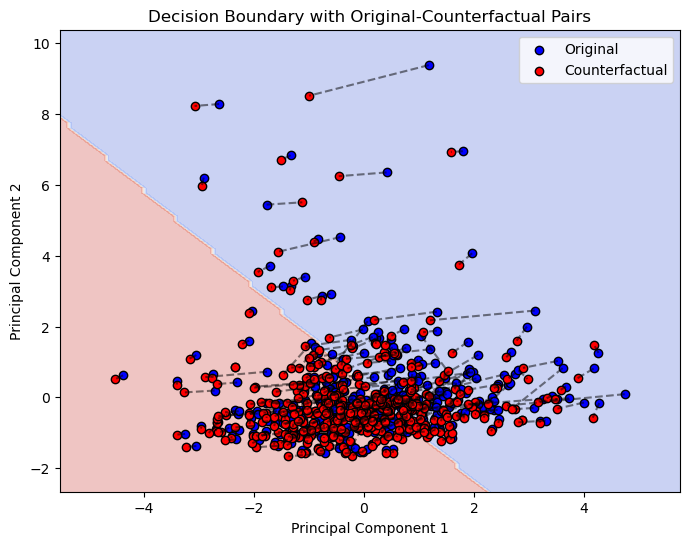

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # Using SVM for clear boundary visualization
from sklearn.preprocessing import StandardScaler

# Load the dataset containing original & counterfactual pairs
df = pd.read_csv('counterfactual_pairs_with_outcomes.csv')

# Drop non-numeric columns if any
df = df.select_dtypes(include=[np.number])

# Extract original and counterfactual points
originals = df.iloc[::2, :-1].values  # Even indices: original instances
counterfactuals = df.iloc[1::2, :-1].values  # Odd indices: counterfactuals

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.vstack((originals, counterfactuals)))

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split PCA transformed data into original and counterfactual
originals_pca = X_pca[:len(originals)]
counterfactuals_pca = X_pca[len(originals):]

# Fit an SVM classifier to visualize decision boundary
y_labels = np.array([0] * len(originals) + [1] * len(counterfactuals))
clf = SVC(kernel='linear')  # Using linear kernel for a clear boundary
clf.fit(X_pca, y_labels)

# Generate mesh grid for decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot original and counterfactual data points
plt.scatter(originals_pca[:, 0], originals_pca[:, 1], c='blue', label='Original', edgecolors='k')
plt.scatter(counterfactuals_pca[:, 0], counterfactuals_pca[:, 1], c='red', label='Counterfactual', edgecolors='k')

# Connect each original-counterfactual pair with a bisector line
for orig, cf in zip(originals_pca, counterfactuals_pca):
    midpoint = (orig + cf) / 2  # Find the midpoint
    plt.plot([orig[0], cf[0]], [orig[1], cf[1]], 'k--', alpha=0.5)  # Draw bisector line

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary with Original-Counterfactual Pairs')
plt.legend()
plt.show()


In [5]:
# Entire training set
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from nice import NICE
import os

# Defining the path for the csv file
path = os.path.join("dataset.csv")

# Storing the dataframe in a variable named dataset
dataset = pd.read_csv(path)

# Dropping the unnecessary columns
dataset = dataset.drop('seqn', axis='columns')
dataset = dataset.drop('Marital', axis='columns')

# Encoding the categorical variables and filling in the missing values
sex_mapping = {'Male': 0, 'Female': 1}
race_mapping = {'White': 0, 'Asian': 1, 'Black': 2, 'MexAmerican': 3, 'Hispanic': 4, 'Other': 5}

dataset['Sex'] = dataset['Sex'].replace(sex_mapping)
dataset['Race'] = dataset['Race'].replace(race_mapping)

# Fill NaN values in column with index 2, 4, and 5
dataset.iloc[:, 2] = dataset.iloc[:, 2].fillna(dataset.iloc[:, 2].mean())
dataset.iloc[:, 4] = dataset.iloc[:, 4].fillna(dataset.iloc[:, 4].mean())
dataset.iloc[:, 5] = dataset.iloc[:, 5].fillna(dataset.iloc[:, 5].mean())

# Splitting the dataset into features and target
X = dataset.drop('MetabolicSyndrome', axis=1)
y = dataset['MetabolicSyndrome']

# Splitting the data into training and testing sets
outcome_0 = dataset[dataset['MetabolicSyndrome'] == 0]
outcome_1 = dataset[dataset['MetabolicSyndrome'] == 1]

test_size_each_class = 400
test_0 = outcome_0.sample(n=test_size_each_class, random_state=42)
test_1 = outcome_1.sample(n=test_size_each_class, random_state=42)
test_data = pd.concat([test_0, test_1])

# Remove the test set rows from the original dataset to create the training set
train_data = dataset.drop(test_data.index)

x_train = train_data.drop('MetabolicSyndrome', axis=1).values
y_train = train_data['MetabolicSyndrome'].values
x_test = test_data.drop('MetabolicSyndrome', axis=1).values
y_test = test_data['MetabolicSyndrome'].values
y_1 = [y for y in y_train if y == 1]
y_0 = [y for y in y_train if y == 0]
print(len(y_1))
print(len(y_0))
'''
# Training an XGBoost classifier
classifier_xgboost = XGBClassifier()
classifier_xgboost.fit(x_train, y_train)

# Defining categorical and numerical features
cat_feat = ['Sex', 'Race']  # Categorical features
num_feat = [
    'Age', 
    'Income',
    'WaistCirc',
    'BMI',
    'Albuminuria',
    'UrAlbCr',
    'UricAcid',
    'BloodGlucose',
    'HDL',
    'Triglycerides'
]

# Get indices of categorical and numerical features from the dataset
feature_indices = {name: idx for idx, name in enumerate(X.columns)}
cat_feat_indices = [feature_indices[feat] for feat in cat_feat]
num_feat_indices = [feature_indices[feat] for feat in num_feat]

# Initializing the NICE explainer
NICE_explainer = NICE(
    X_train=x_train,
    predict_fn=classifier_xgboost.predict_proba,
    y_train=y_train,
    cat_feat=cat_feat_indices,
    num_feat=num_feat_indices
)

# Modified function to generate counterfactual examples for all opposite class instances
def generate_counterfactuals_with_predictions(explainer, classifier, x_train, y_train):
    # Find all indices where y_train is 0 and 1
    class_0_indices = np.where(y_train == 0)[0]
    class_1_indices = np.where(y_train == 1)[0]
    
    # Initialize lists to store results
    counterfactuals = []
    original_instances = []
    original_predictions = []
    counterfactual_predictions = []
    
    # Process all instances of class 0 (finding counterfactuals for class 1)
    total_instances = len(class_0_indices)
    for i, idx in enumerate(class_0_indices):
        try:
            instance = x_train[idx].reshape(1, -1)
            cf_example = explainer.explain(instance)
            
            # Get predictions
            orig_pred = classifier.predict(instance)[0]
            cf_pred = classifier.predict(cf_example)[0]
            
            counterfactuals.append(cf_example)
            original_instances.append(instance)
            original_predictions.append(orig_pred)
            counterfactual_predictions.append(cf_pred)
            
            print(f"Processing class 0 instance {i + 1}/{total_instances}")
        except Exception as e:
            print(f"Error processing instance {i}: {str(e)}")
            continue
    
    # Process all instances of class 1 (finding counterfactuals for class 0)
    total_instances = len(class_1_indices)
    for i, idx in enumerate(class_1_indices):
        try:
            instance = x_train[idx].reshape(1, -1)
            cf_example = explainer.explain(instance)
            
            # Get predictions
            orig_pred = classifier.predict(instance)[0]
            cf_pred = classifier.predict(cf_example)[0]
            
            counterfactuals.append(cf_example)
            original_instances.append(instance)
            original_predictions.append(orig_pred)
            counterfactual_predictions.append(cf_pred)
            
            print(f"Processing class 1 instance {i + 1}/{total_instances}")
        except Exception as e:
            print(f"Error processing instance {i}: {str(e)}")
            continue
    
    return original_instances, counterfactuals, original_predictions, counterfactual_predictions

# Generating counterfactual examples with predictions for all instances
print("Starting counterfactual generation...")
original_instances, counterfactuals, original_predictions, counterfactual_predictions = \
    generate_counterfactuals_with_predictions(NICE_explainer, classifier_xgboost, x_train, y_train)
print("Finished generating counterfactuals.")

# Converting counterfactual examples to a DataFrame
print("Converting results to DataFrame...")
feature_names = X.columns
counterfactual_dfs = [pd.DataFrame(cf, columns=feature_names) for cf in counterfactuals]
original_dfs = [pd.DataFrame(orig, columns=feature_names) for orig in original_instances]

# Creating pairs of original and counterfactual examples with predictions
pairs = []
for i, (orig, cf) in enumerate(zip(original_dfs, counterfactual_dfs)):
    # Add prediction columns
    orig['Outcome'] = original_predictions[i]
    cf['Outcome'] = counterfactual_predictions[i]
    
    pair = pd.concat([orig, cf], axis=0)
    pair.index = ['Original', 'Counterfactual']
    pairs.append(pair)

# Concatenating all pairs into a single DataFrame
result_df = pd.concat(pairs, axis=0)

# Exporting the result to a CSV file
print("Saving results to CSV...")
result_df.to_csv('counterfactual_pairs_all_with_outcomes.csv', index=True)

print("Counterfactual pairs with outcomes have been saved to 'counterfactual_pairs_all_with_outcomes.csv'")
'''

422
1179


'\n# Training an XGBoost classifier\nclassifier_xgboost = XGBClassifier()\nclassifier_xgboost.fit(x_train, y_train)\n\n# Defining categorical and numerical features\ncat_feat = [\'Sex\', \'Race\']  # Categorical features\nnum_feat = [\n    \'Age\', \n    \'Income\',\n    \'WaistCirc\',\n    \'BMI\',\n    \'Albuminuria\',\n    \'UrAlbCr\',\n    \'UricAcid\',\n    \'BloodGlucose\',\n    \'HDL\',\n    \'Triglycerides\'\n]\n\n# Get indices of categorical and numerical features from the dataset\nfeature_indices = {name: idx for idx, name in enumerate(X.columns)}\ncat_feat_indices = [feature_indices[feat] for feat in cat_feat]\nnum_feat_indices = [feature_indices[feat] for feat in num_feat]\n\n# Initializing the NICE explainer\nNICE_explainer = NICE(\n    X_train=x_train,\n    predict_fn=classifier_xgboost.predict_proba,\n    y_train=y_train,\n    cat_feat=cat_feat_indices,\n    num_feat=num_feat_indices\n)\n\n# Modified function to generate counterfactual examples for all opposite class ins

In [ ]:
# Takes too long
# Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from nice import NICE
import os

# Defining the path for the csv file
path = os.path.join("dataset.csv")

# Storing the dataframe in a variable named dataset
dataset = pd.read_csv(path)

# Dropping the unnecessary columns
dataset = dataset.drop('seqn', axis='columns')
dataset = dataset.drop('Marital', axis='columns')

# Encoding the categorical variables and filling in the missing values
sex_mapping = {'Male': 0, 'Female': 1}
race_mapping = {'White': 0, 'Asian': 1, 'Black': 2, 'MexAmerican': 3, 'Hispanic': 4, 'Other': 5}

dataset['Sex'] = dataset['Sex'].replace(sex_mapping)
dataset['Race'] = dataset['Race'].replace(race_mapping)

# Fill NaN values in column with index 2, 4, and 5
dataset.iloc[:, 2] = dataset.iloc[:, 2].fillna(dataset.iloc[:, 2].mean())
dataset.iloc[:, 4] = dataset.iloc[:, 4].fillna(dataset.iloc[:, 4].mean())
dataset.iloc[:, 5] = dataset.iloc[:, 5].fillna(dataset.iloc[:, 5].mean())

# Splitting the dataset into features and target
X = dataset.drop('MetabolicSyndrome', axis=1)
y = dataset['MetabolicSyndrome']

# Splitting the data into training and testing sets
outcome_0 = dataset[dataset['MetabolicSyndrome'] == 0]
outcome_1 = dataset[dataset['MetabolicSyndrome'] == 1]

test_size_each_class = 400
test_0 = outcome_0.sample(n=test_size_each_class, random_state=42)
test_1 = outcome_1.sample(n=test_size_each_class, random_state=42)
test_data = pd.concat([test_0, test_1])

# Remove the test set rows from the original dataset to create the training set
train_data = dataset.drop(test_data.index)

x_train = train_data.drop('MetabolicSyndrome', axis=1).values
y_train = train_data['MetabolicSyndrome'].values
x_test = test_data.drop('MetabolicSyndrome', axis=1).values
y_test = test_data['MetabolicSyndrome'].values

# Training an XGBoost classifier
classifier_xgboost = XGBClassifier()
classifier_xgboost.fit(x_train, y_train)

# Defining categorical and numerical features
cat_feat = ['Sex', 'Race']  # Categorical features
num_feat = [
    'Age', 
    'Income',
    'WaistCirc',
    'BMI',
    'Albuminuria',
    'UrAlbCr',
    'UricAcid',
    'BloodGlucose',
    'HDL',
    'Triglycerides'
]

# Get indices of categorical and numerical features from the dataset
feature_indices = {name: idx for idx, name in enumerate(X.columns)}
cat_feat_indices = [feature_indices[feat] for feat in cat_feat]
num_feat_indices = [feature_indices[feat] for feat in num_feat]

# Initializing the NICE explainer
NICE_explainer = NICE(
    X_train=x_train,
    predict_fn=classifier_xgboost.predict_proba,
    y_train=y_train,
    cat_feat=cat_feat_indices,
    num_feat=num_feat_indices
)

# Function to generate counterfactual examples for all instances in the opposite class
def generate_counterfactuals_for_all_opposite_class(explainer, x_train, y_train):
    counterfactuals = []
    original_instances = []
    original_outcomes = []
    counterfactual_outcomes = []
    
    # Iterate through all instances in the training set
    for idx in range(len(x_train)):
        instance = x_train[idx].reshape(1, -1)
        instance_class = y_train[idx]
        opposite_class = 1 - instance_class
        
        # Find indices of instances in the opposite class
        opposite_class_indices = np.where(y_train == opposite_class)[0]
        
        # Generate counterfactuals for all opposite class instances
        for opp_idx in opposite_class_indices:
            opposite_instance = x_train[opp_idx].reshape(1, -1)
            cf_example = explainer.explain(opposite_instance)
            counterfactuals.append(cf_example)
            original_instances.append(opposite_instance)
            
            # Record the original and counterfactual outcomes
            original_outcomes.append(opposite_class)  # Original instance's class
            counterfactual_outcomes.append(instance_class)  # Counterfactual's target class
    
    return original_instances, counterfactuals, original_outcomes, counterfactual_outcomes

# Generating counterfactual examples for all instances in the opposite class
original_instances, counterfactuals, original_outcomes, counterfactual_outcomes = generate_counterfactuals_for_all_opposite_class(NICE_explainer, x_train, y_train)

# Converting counterfactual examples to a DataFrame
feature_names = X.columns
counterfactual_dfs = [pd.DataFrame(cf, columns=feature_names) for cf in counterfactuals]
original_dfs = [pd.DataFrame(orig, columns=feature_names) for orig in original_instances]

# Adding outcome columns to the DataFrames
for i in range(len(original_dfs)):
    original_dfs[i]['Outcome'] = original_outcomes[i]  # Add original outcome
    counterfactual_dfs[i]['Outcome'] = counterfactual_outcomes[i]  # Add counterfactual outcome

# Creating pairs of original and counterfactual examples
pairs = []
for orig, cf in zip(original_dfs, counterfactual_dfs):
    pair = pd.concat([orig, cf], axis=0)
    pair.index = ['Original', 'Counterfactual']
    pairs.append(pair)

# Concatenating all pairs into a single DataFrame
result_df = pd.concat(pairs, axis=0)

# Exporting the result to a CSV file
result_df.to_csv('counterfactual_pairs_all_with_outcomes.csv', index=True)

print("Counterfactual pairs with outcomes have been saved to 'counterfactual_pairs_all_with_outcomes.csv'")

In [3]:
# Encoding the categorical variables and filling in the missing values
sex_mapping = {'Male': 0, 'Female': 1}
race_mapping = {'White': 0, 'Asian': 1, 'Black': 2, 'MexAmerican': 3, 'Hispanic': 4, 'Other': 5}

dataset['Sex'] = dataset['Sex'].replace(sex_mapping)
dataset['Race'] = dataset['Race'].replace(race_mapping)
'''
dataset = dataset.fillna(2)
dataset = dataset.fillna(4)
dataset = dataset.fillna(5)
'''
# Fill NaN values in column with index 2
dataset.iloc[:, 2] = dataset.iloc[:, 2].fillna(dataset.iloc[:, 2].mean())

# Fill NaN values in column with index 4
dataset.iloc[:, 4] = dataset.iloc[:, 4].fillna(dataset.iloc[:, 4].mean())

# Fill NaN values in column with index 5
dataset.iloc[:, 5] = dataset.iloc[:, 5].fillna(dataset.iloc[:, 5].mean())

In [ ]:
outcome_0 = dataset[dataset['MetabolicSyndrome'] == 0]
outcome_1 = dataset[dataset['MetabolicSyndrome'] == 1]


test_size_each_class = 400
test_0 = outcome_0.sample(n=test_size_each_class, random_state=42)
test_1 = outcome_1.sample(n=test_size_each_class, random_state=42)
print(test_1)
test_data = pd.concat([test_0, test_1])

# Remove the test set rows from the original dataset to create the training set
train_data = dataset.drop(test_data.index)


x_train = train_data.drop('MetabolicSyndrome', axis=1).values
y_train = train_data['MetabolicSyndrome'].values
x_test = test_data.drop('MetabolicSyndrome', axis=1).values
y_test = test_data['MetabolicSyndrome'].values

# Resampling the data to avoid overfitting
ros = RandomOverSampler(random_state=0)

# Resampling the data
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

# Making the Random Classifier model
classifier = RandomForestClassifier(n_estimators=30, criterion='entropy', random_state=0)

# Training the model
classifier.fit(x_resampled, y_resampled)

# Predicting the results 
y_pred = classifier.predict(x_test)

# Getting accuracy results and confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
print("Confusion matrix: ")
print(cm, "\n")
print("Precision Score: ")
print("\t",precision_score(y_test, y_pred), "\n")
print("Recall: ")
print("\t", recall_score(y_test, y_pred), "\n")
print("F1 Score: ")
print("\t", f1_score(y_test, y_pred), "\n")


In [ ]:
# Decision Tree Classifier
classifier_decision_tree = DecisionTreeClassifier(criterion='entropy')
classifier_decision_tree.fit(x_resampled, y_resampled)
y_pred = classifier_decision_tree.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
print("Confusion matrix: ")
print(cm, "\n")
print("Precision Score: ")
print("\t",precision_score(y_test, y_pred), "\n")
print("Recall: ")
print("\t", recall_score(y_test, y_pred), "\n")
print("F1 Score: ")
print("\t", f1_score(y_test, y_pred), "\n")

In [ ]:
# XGBoost Classifier
classifier_xgboost = XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.5)
classifier_xgboost.fit(x_resampled, y_resampled)
joblib.dump(classifier_xgboost, 'xgboost_classifier.pkl')
y_pred = classifier_xgboost.predict(x_test)
for i in x_test[0]:
    print(type(i))



cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
print("Confusion matrix: ")
print(cm, "\n")
print("Precision Score: ")
print("\t",precision_score(y_test, y_pred), "\n")
print("Recall: ")
print("\t", recall_score(y_test, y_pred), "\n")
print("F1 Score: ")
print("\t", f1_score(y_test, y_pred), "\n")

In [ ]:
from nice import NICE
cat_feat = ['Sex', 'Race']  # Categorical features

num_feat = [
    'Age', 
    'Income',
    'WaistCirc',
    'BMI',
    'Albuminuria',
    'UrAlbCr',
    'UricAcid',
    'BloodGlucose',
    'HDL',
    'Triglycerides'
]

# Get indices of categorical and numerical features from the dataset
# We need to map feature names to their column indices
feature_indices = {name: idx for idx, name in enumerate(dataset.drop('MetabolicSyndrome', axis=1).columns)}

cat_feat_indices = [feature_indices[feat] for feat in cat_feat]
num_feat_indices = [feature_indices[feat] for feat in num_feat]
NICE_explainer = NICE(
    X_train=x_train,
    predict_fn=classifier_xgboost.predict_proba,
    y_train=y_train,

    cat_feat=cat_feat_indices,
    num_feat=num_feat_indices
)
# Select an instance for explanation
# Select an instance correctly (assuming X_test is a NumPy array)
instance_idx = 0  # Change this index based on which instance you want to explain
instance = x_test[instance_idx].reshape(1, -1)  # Ensure it's 2D

# Generate counterfactual explanation
cf_example = NICE_explainer.explain(instance)


# View the counterfactual example

import pandas as pd

# Feature names
feature_names = dataset.drop('MetabolicSyndrome', axis=1).columns

# Convert counterfactual explanation to a DataFrame
cf_df = pd.DataFrame(cf_example, columns=feature_names)

print("Counterfactual Explanation (Readable Format):")
#print(cf_df)
# Convert the original instance to a DataFrame
original_instance = pd.DataFrame(instance, columns=feature_names)

# Compare the original and counterfactual
comparison = pd.concat([original_instance, cf_df], axis=0)
comparison.index = ['Original', 'Counterfactual']

print("Comparison of Original and Counterfactual:")
print(comparison)


In [ ]:
cf_examples = NICE_explainer.generate_counterfactual(instance, nb_cf=5)  # Generate 5 counterfactuals
cf_df = pd.DataFrame(cf_examples, columns=feature_names)

print(cf_df)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the classifier
importance = classifier_xgboost.feature_importances_

# Sort feature importance in descending order
sorted_idx = np.argsort(importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(np.array(feature_names)[sorted_idx], importance[sorted_idx])
plt.xticks(rotation=45)
plt.ylabel("Importance Score")
plt.title("Feature Importance in XGBoost Model")
plt.show()


In [ ]:
from nice import NICE
import numpy as np

# Define categorical and numerical features based on the dataset structure
cat_feat = ['Sex', 'Race']  # Categorical features
num_feat = [
    'Age', 
    'Income',
    'WaistCirc',
    'BMI',
    'Albuminuria',
    'UrAlbCr',
    'UricAcid',
    'BloodGlucose',
    'HDL',
    'Triglycerides'
]

# Get indices of categorical and numerical features from the dataset
feature_indices = {name: idx for idx, name in enumerate(dataset.drop('MetabolicSyndrome', axis=1).columns)}

cat_feat_indices = [feature_indices[feat] for feat in cat_feat]
num_feat_indices = [feature_indices[feat] for feat in num_feat]

# Create prediction function wrapper for XGBoost model
def predict_fn(X):
    if isinstance(X, np.ndarray):
        return classifier.predict_proba(X)
    return classifier.predict_proba(X.values)

# Initialize NICE explainer
NICE_explainer = NICE(
    X_train=x_resampled,
    predict_fn=predict_fn,
    y_train=y_resampled,
    cat_feat=cat_feat_indices,
    num_feat=num_feat_indices
)

def explain_instance(instance_idx):
    # Get instance to explain and reshape to 2D array
    x_to_explain = x_test[instance_idx].reshape(1, -1)
    
    # Generate explanation
    explanation = NICE_explainer.explain(x_to_explain)
    
    # Get feature names
    feature_names = list(dataset.drop('MetabolicSyndrome', axis=1).columns)
    
    # Print original prediction
    original_pred = classifier.predict(x_to_explain)[0]
    print(f"Original instance prediction: {'Positive' if original_pred == 1 else 'Negative'} for Metabolic Syndrome")
    
    # Print counterfactual
    counterfactual = explanation['counterfactual']
    cf_pred = classifier.predict(counterfactual.reshape(1, -1))[0]
    print(f"\nCounterfactual prediction: {'Positive' if cf_pred == 1 else 'Negative'} for Metabolic Syndrome")
    
    # Print feature changes
    print("\nFeature changes:")
    for i, (orig, cf) in enumerate(zip(x_to_explain[0], counterfactual)):
        feature_name = feature_names[i]
        
        # Special handling for categorical variables
        if feature_name == 'Sex':
            orig_val = 'Male' if orig == 0 else 'Female'
            cf_val = 'Male' if cf == 0 else 'Female'
            print(f"{feature_name}: {orig_val} -> {cf_val}")
        elif feature_name == 'Race':
            race_labels = {0: 'White', 1: 'Asian', 2: 'Black', 
                         3: 'MexAmerican', 4: 'Hispanic', 5: 'Other'}
            orig_val = race_labels.get(int(orig), 'Unknown')
            cf_val = race_labels.get(int(cf), 'Unknown')
            print(f"{feature_name}: {orig_val} -> {cf_val}")
        else:
            # Format numerical changes with appropriate precision
            print(f"{feature_name}: {orig:.2f} -> {cf:.2f} (change: {cf-orig:.2f})")

# Function to explain multiple instances
def explain_multiple_instances(n_instances=5):
    print(f"Explaining {n_instances} predictions:\n")
    for i in range(n_instances):
        print(f"\nInstance {i+1}:")
        print("-" * 50)
        explain_instance(i)

# Example usage
print("Example explanation for first test instance:")
explain_instance(1)

In [ ]:
# Logistic Regression
classifier_logistic_regression = LogisticRegression()

classifier_logistic_regression.fit(x_resampled, y_resampled)
y_pred = classifier_logistic_regression.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
print("Confusion matrix: ")
print(cm, "\n")
print("Precision Score: ")
print("\t",precision_score(y_test, y_pred), "\n")
print("Recall: ")
print("\t", recall_score(y_test, y_pred), "\n")
print("F1 Score: ")
print("\t", f1_score(y_test, y_pred), "\n")

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=10)
mlp.fit(x_resampled, y_resampled)
y_pred = mlp.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
print("Confusion matrix: ")
print(cm, "\n")
print("Precision Score: ")
print("\t",precision_score(y_test, y_pred), "\n")
print("Recall: ")
print("\t", recall_score(y_test, y_pred), "\n")
print("F1 Score: ")
print("\t", f1_score(y_test, y_pred), "\n")
mlp_accuracy = mlp.score(x_test, y_test)

In [ ]:
tabnet = TabNetClassifier()
tabnet.fit(
    x_resampled, y_resampled,
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
y_pred = tabnet.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
print("Confusion matrix: ")
print(cm, "\n")
print("Precision Score: ")
print("\t",precision_score(y_test, y_pred), "\n")
print("Recall: ")
print("\t", recall_score(y_test, y_pred), "\n")
print("F1 Score: ")
print("\t", f1_score(y_test, y_pred), "\n")


In [9]:
from datetime import datetime
def evaluate_and_store_metrics(models_dict, X_test, y_test, csv_filename='model_metrics_2.csv', spacing_rows=5):
    """
    Evaluate multiple models and store their metrics in a CSV file with spacing between different runs.
    
    Parameters:
    models_dict: Dictionary of model names and their corresponding trained model objects
    X_test: Test features
    y_test: Test labels
    csv_filename: Name of the output CSV file
    spacing_rows: Number of blank rows to add before new results
    """
    # Create a list to store results
    results = []
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    version = "ROS on training data"
    
    # Evaluate each model
    for model_name, model in models_dict.items():
        y_pred = model.predict(X_test)
        
        results.append({
            'version': version,
            'timestamp': timestamp,
            'model_name': model_name,
            'accuracy': round(accuracy_score(y_test, y_pred) * 100, 2),
            'precision': round(precision_score(y_test, y_pred), 4),
            'recall': round(recall_score(y_test, y_pred), 4),
            'f1_score': round(f1_score(y_test, y_pred), 4)
        })
    
    results_df = pd.DataFrame(results)
    
    try:
        # Read existing CSV
        existing_df = pd.read_csv(csv_filename)
        
        # Create empty rows for spacing
        empty_rows = pd.DataFrame([{'timestamp': '', 'model_name': '', 'accuracy': '', 
                                  'precision': '', 'recall': '', 'f1_score': ''}] * spacing_rows)
        
        # Concatenate existing data, empty rows, and new results
        final_df = pd.concat([existing_df, empty_rows, results_df], ignore_index=True)
        
    except FileNotFoundError:
        final_df = results_df
    
    # Save to CSV without index
    final_df.to_csv(csv_filename, index=False)
    
    return results_df

def run_evaluation(dataset, test_size_each_class=400, random_state=42):
    """
    Run the complete evaluation pipeline including data splitting and model training.
    """
    # Split data
    outcome_0 = dataset[dataset['MetabolicSyndrome'] == 0]
    outcome_1 = dataset[dataset['MetabolicSyndrome'] == 1]
    
    test_0 = outcome_0.sample(n=test_size_each_class, random_state=random_state)
    test_1 = outcome_1.sample(n=test_size_each_class, random_state=random_state)
    test_data = pd.concat([test_0, test_1])
    
    # Create training set
    train_data = dataset.drop(test_data.index)
    
    # Prepare features and labels
    X_train = train_data.drop('MetabolicSyndrome', axis=1).values
    y_train = train_data['MetabolicSyndrome'].values
    X_test = test_data.drop('MetabolicSyndrome', axis=1).values
    y_test = test_data['MetabolicSyndrome'].values
    
    # Resample training data only
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    # Initialize and train models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=30, criterion='entropy', random_state=0),
        'Decision Tree': DecisionTreeClassifier(criterion='entropy'),
        'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.5),
        'Logistic Regression': LogisticRegression(),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=10),
        'TabNet': TabNetClassifier()
    }
    
    # Train each model
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        if model_name == 'TabNet':
            model.fit(
                X_resampled, y_resampled,
                max_epochs=100,
                patience=10,
                batch_size=1024,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False
            )
        else:
            model.fit(X_resampled, y_resampled)
    
    # Evaluate and store results
    results = evaluate_and_store_metrics(models, X_test, y_test)
    
    return results

In [ ]:
results = run_evaluation(dataset)
print(results)

In [ ]:
model_saved = joblib.load('best_xgboost_model.pkl')
y_pred = model_saved.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Accracy: ")
print(f'\t{(accuracy_score(y_test, y_pred) * 100):.2f}% is the accuracy\n')
